## Introduction

In this notebook, I simulate a complete pipeline for matching synthetic real-estate leads with synthetic property listings in Mumbai and cluster these lead-property pairs based on multiple engineered features. This can be useful for targeting marketing efforts, personalizing communication, or prioritizing follow-up with promising leads.

## 1. General Synthetic Leads


Objective: Create a simulated dataset of 1000 potential buyers (leads) with realistic demographics, engagement metrics, and location coordinates around Mumbai.


*   Used numpy to randomly generate features like age, income, marital status, etc.
*   Engagement behaviors (visits, downloads, dwell time) were included.
*   Location coordinates were centered around Mumbai.


Output: leads DataFrame saved as synthetic_leads_with_customer_id.csv




In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# 1. Generate synthetic leads
def generate_synthetic_leads(N=1000, seed=42):
    np.random.seed(seed)
    # Demographics
    ages = np.random.normal(35, 8, N).clip(21, 65).astype(int)
    incomes = np.random.normal(20, 5, N).clip(5, 50).round(1)
    family_sizes = np.random.choice([1,2,3,4,5], N, p=[0.2,0.3,0.3,0.15,0.05])
    marital_statuses = np.random.choice(['single','married'], N, p=[0.4,0.6])
    # Geography (around Mumbai)
    lats = np.random.normal(19.07, 0.1, N).round(5)
    lons = np.random.normal(72.88, 0.1, N).round(5)
    # Engagement
    visits = np.random.poisson(2, N)
    days_since = np.random.exponential(15, N).clip(0,60).round().astype(int)
    dwell = np.random.exponential(10, N).round(1)
    downloads = np.random.poisson(1, N)
    # Channel flags
    companion = np.random.choice([0,1], N, p=[0.7,0.3])
    broker    = np.random.choice([0,1], N, p=[0.8,0.2])
    open_house = np.random.choice([0,1], N, p=[0.9,0.1])
    finance_flag = np.random.choice([0,1], N, p=[0.85,0.15])

    return pd.DataFrame({
        'age': ages,
        'income_lpa': incomes,
        'family_size': family_sizes,
        'marital_status': marital_statuses,
        'home_lat': lats,
        'home_lon': lons,
        'visits_last_30d': visits,
        'days_since_last_visit': days_since,
        'dwell_time_mins': dwell,
        'downloads': downloads,
        'companion_flag': companion,
        'broker_flag': broker,
        'open_house_flag': open_house,
        'finance_brochure_flag': finance_flag
    })

# 2. Create DataFrame
leads = generate_synthetic_leads()




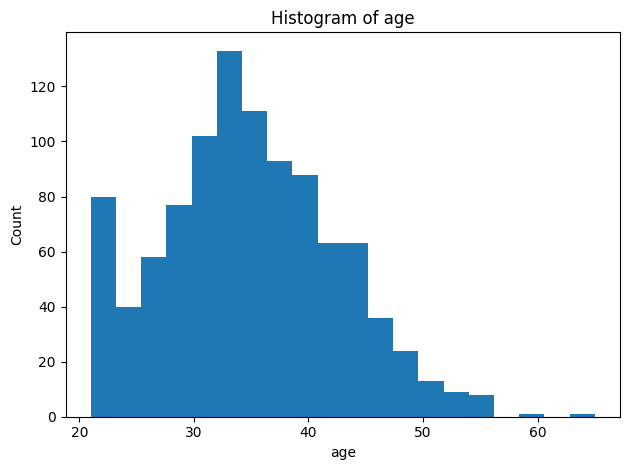

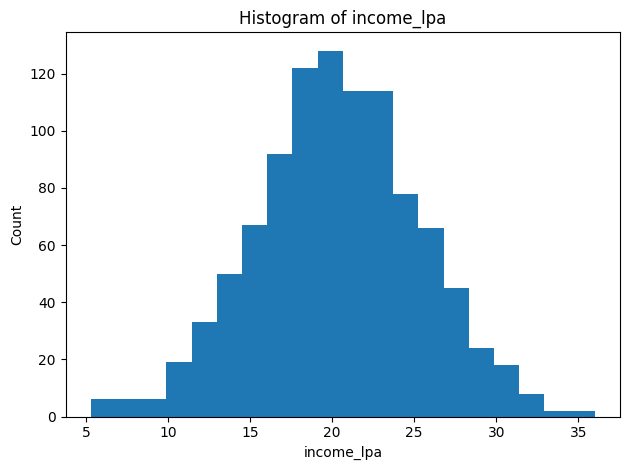

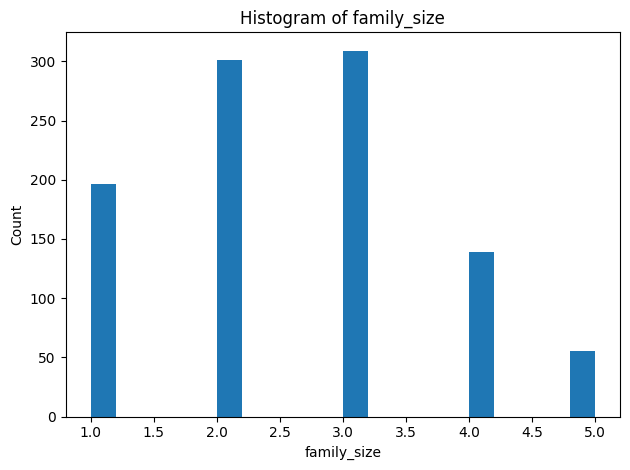

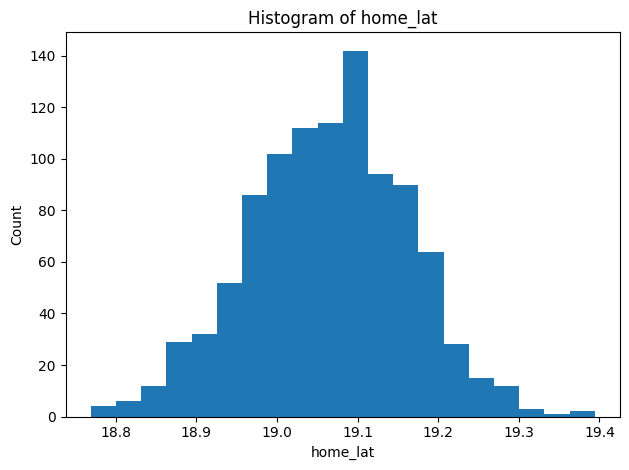

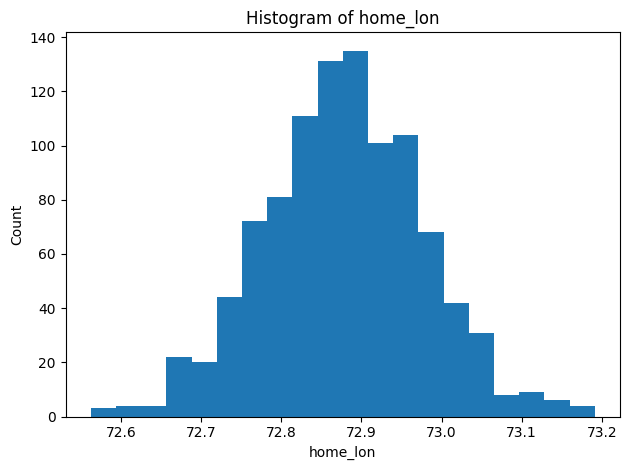

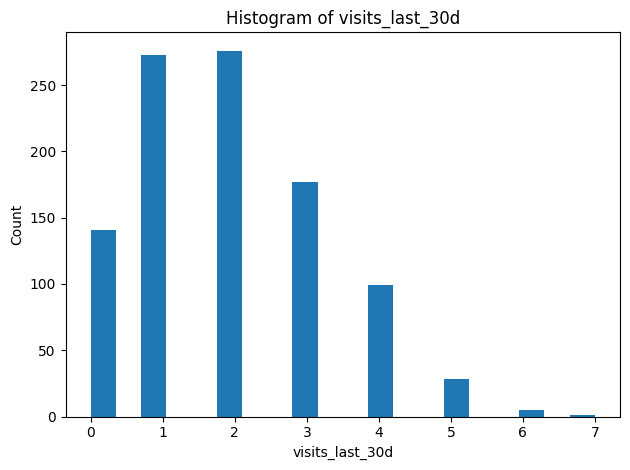

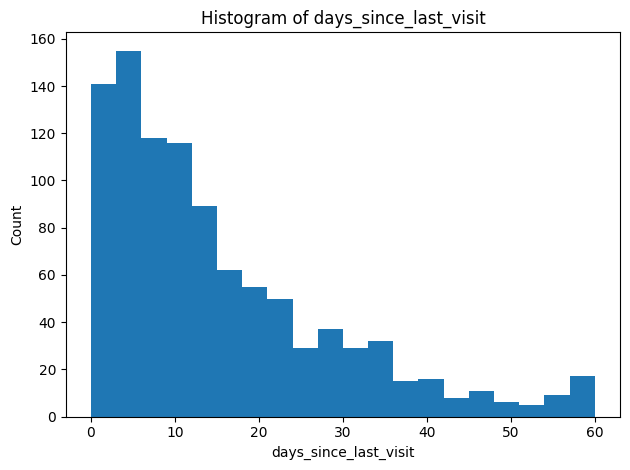

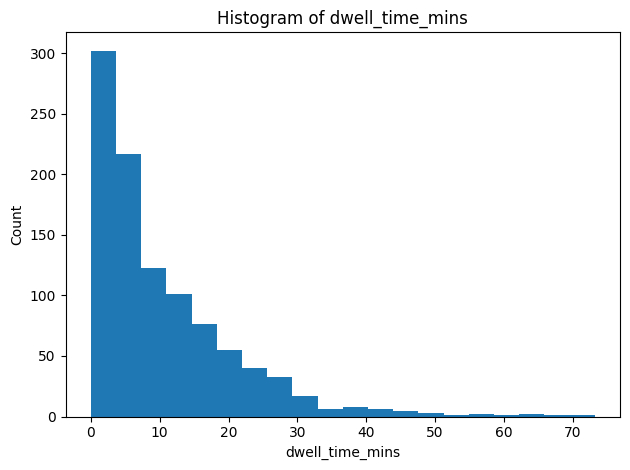

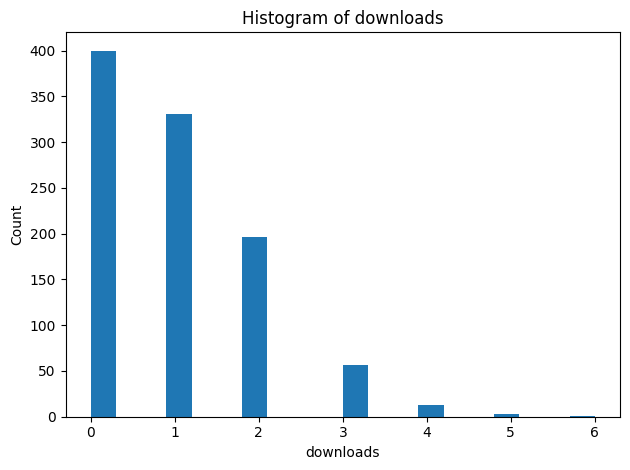

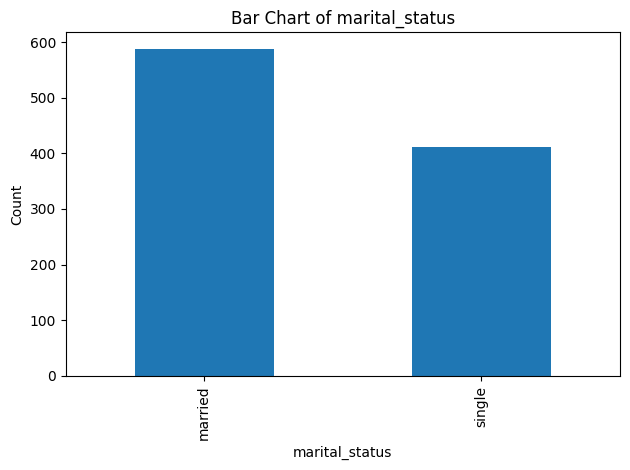

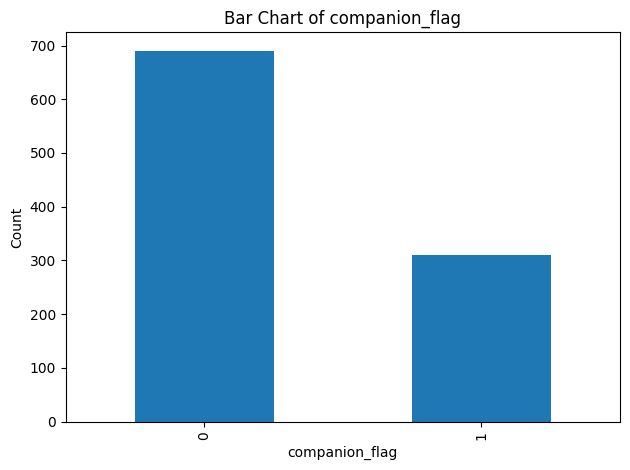

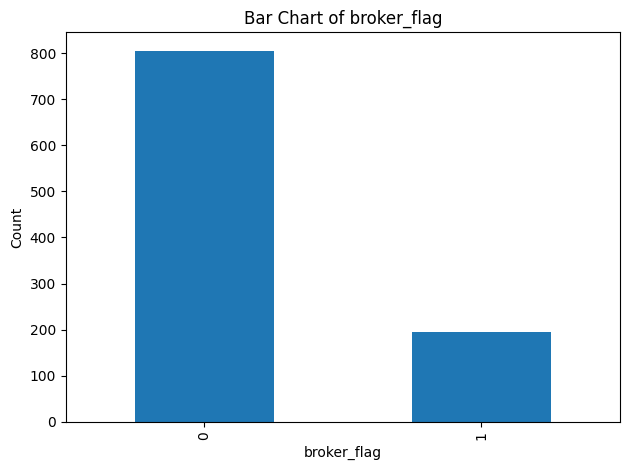

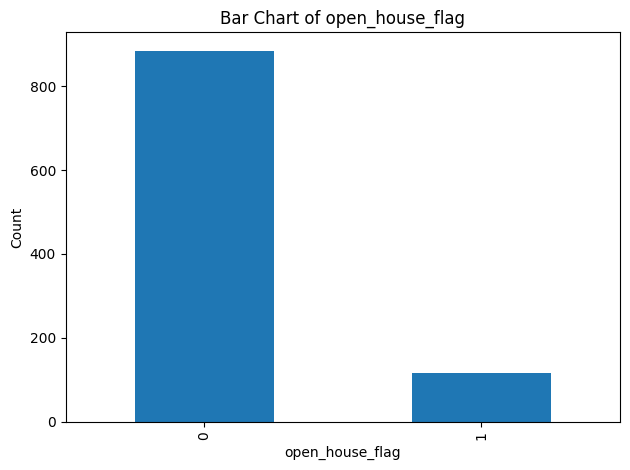

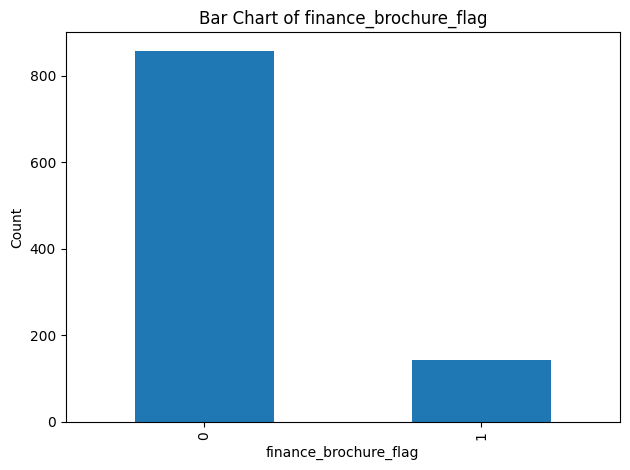

In [ ]:
# 3. Plot numeric feature histograms
numeric_features = [
    'age', 'income_lpa', 'family_size',
    'home_lat', 'home_lon',
    'visits_last_30d', 'days_since_last_visit',
    'dwell_time_mins', 'downloads'
]
for feature in numeric_features:
    plt.figure()
    plt.hist(leads[feature], bins=20)
    plt.title(f'Histogram of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

# 4. Plot categorical/binary feature bar charts
binary_features = [
    'marital_status', 'companion_flag',
    'broker_flag', 'open_house_flag',
    'finance_brochure_flag'
]
for feature in binary_features:
    plt.figure()
    leads[feature].value_counts().sort_index().plot(kind='bar')
    plt.title(f'Bar Chart of {feature}')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.tight_layout()
    plt.show()

In [ ]:
# Assuming you have a DataFrame `leads` already:
leads.insert(0, 'customer_id', [f'c{i+1}' for i in range(len(leads))])

# Optionally save it out:
leads.to_csv('synthetic_leads_with_customer_id.csv', index=False)


In [ ]:
# After you’ve generated `leads` as above:

# 1️⃣ Save to CSV in your working directory
leads.to_csv('synthetic_leads.csv', index=False)

# 2️⃣ Verify by printing the first few lines
import os
print("File saved at:", os.path.abspath('synthetic_leads.csv'))
!head -n 10 synthetic_leads.csv


File saved at: /content/synthetic_leads.csv
customer_id,age,income_lpa,family_size,marital_status,home_lat,home_lon,visits_last_30d,days_since_last_visit,dwell_time_mins,downloads,companion_flag,broker_flag,open_house_flag,finance_brochure_flag
c1,38,27.0,2,single,19.17684,72.81864,1,4,26.8,1,1,0,0,0
c2,33,24.6,1,married,19.13041,72.89962,0,2,5.1,0,0,1,0,1
c3,40,20.3,2,married,19.30036,72.93458,2,5,30.6,1,0,0,0,1
c4,47,16.8,1,single,18.92206,72.66284,3,3,12.1,2,1,0,0,0
c5,33,23.5,4,married,19.19592,72.87919,2,0,0.4,0,0,0,0,0
c6,33,22.0,4,married,19.18464,72.89581,2,36,23.7,2,0,0,1,0
c7,47,24.5,1,single,18.97266,72.85225,1,0,6.6,0,0,0,0,0
c8,41,23.2,5,married,19.17071,73.00913,0,20,6.2,1,0,0,0,1
c9,31,25.2,3,single,19.10361,72.92218,2,2,8.4,2,0,1,0,1


## 2. Generate Synthetic Property Listings

Objective: Simulate 15 residential projects in Goregaon West, Mumbai.
Each project has a location, unit type (1BHK/2BHK/3BHK), price (based on area and psf), launch date, and number of units.

*  Each project has a location, unit type (1BHK/2BHK/3BHK), price (based on area and psf), launch date, and number of units.



Output: props DataFrame saved as synthetic_properties.csv

In [ ]:
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

def generate_synthetic_properties(M=15, seed=123):
    np.random.seed(seed)
    # 1. IDs and names
    project_ids = [f"P{i:03d}" for i in range(1, M+1)]
    location_names = ["Goregaon West"] * M

    # 2. Random geo coords around Goregaon West (~19.15,72.85)
    lats = np.random.normal(19.15, 0.02, M).round(5)
    lons = np.random.normal(72.85, 0.02, M).round(5)

    # 3. Unit types and areas
    unit_types = np.random.choice(["1BHK","2BHK","3BHK"], M, p=[0.5,0.3,0.2])
    carpet_areas = np.where(unit_types=="1BHK",
                            np.random.randint(350, 500, M),
                            np.where(unit_types=="2BHK",
                                     np.random.randint(500, 800, M),
                                     np.random.randint(800, 1200, M)))

    # 4. Prices: price/sqft between ₹12-20 k
    psf = np.random.uniform(12, 20, M) * 1e3
    prices = (carpet_areas * psf / 1e7).round(2)  # in crores

    # 5. Launch dates over the past 3 years
    start = datetime.today() - timedelta(days=3*365)
    launch_dates = [start + timedelta(days=int(x))
                    for x in np.random.uniform(0,3*365, M)]
    launch_dates = [d.date().isoformat() for d in launch_dates]

    # 6. Amenities and availability
    amenities = np.random.randint(5, 20, M)   # number of nearby amenities
    units_avail = np.random.randint(5, 100, M)

    props_df = pd.DataFrame({
        "project_id": project_ids,
        "location_name": location_names,
        "lat": lats,
        "lon": lons,
        "unit_type": unit_types,
        "carpet_area_sqft": carpet_areas,
        "price_cr": prices,
        "launch_date": launch_dates,
        "amenities_score": amenities,
        "units_available": units_avail
    })
    return props_df

# Generate & preview
props = generate_synthetic_properties(M=15)
print(props)


   project_id  location_name       lat       lon unit_type  carpet_area_sqft  \
0        P001  Goregaon West  19.12829  72.84131      1BHK               451   
1        P002  Goregaon West  19.16995  72.89412      1BHK               375   
2        P003  Goregaon West  19.15566  72.89374      1BHK               406   
3        P004  Goregaon West  19.11987  72.87008      1BHK               399   
4        P005  Goregaon West  19.13843  72.85772      1BHK               362   
5        P006  Goregaon West  19.18303  72.86475      3BHK              1160   
6        P007  Goregaon West  19.10147  72.87981      3BHK               909   
7        P008  Goregaon West  19.14142  72.83128      2BHK               765   
8        P009  Goregaon West  19.17532  72.87352      2BHK               587   
9        P010  Goregaon West  19.13267  72.82492      1BHK               398   
10       P011  Goregaon West  19.13642  72.83724      1BHK               406   
11       P012  Goregaon West  19.14811  

In [ ]:
props.to_csv("synthetic_properties.csv", index=False)


## 3. Load Datasets

Objective: Import both leads and property datasets for further processing.


*   Read CSV files
synthetic_leads_with_customer_id.csv and synthetic_properties.csv



In [ ]:
import pandas as pd

# Replace with your actual CSV paths
LEADS_CSV = '/content/synthetic_leads_with_customer_id.csv'
PROPS_CSV = '/content/synthetic_properties.csv'

# 1️⃣ Load Leads
leads_df = pd.read_csv(LEADS_CSV)
print("Leads data preview:")
print(leads_df.head())

# 2️⃣ Load Properties
props_df = pd.read_csv(PROPS_CSV)
print("\nProperties data preview:")
print(props_df.head())


Leads data preview:
  customer_id  age  income_lpa  family_size marital_status  home_lat  \
0          c1   38        27.0            2         single  19.17684   
1          c2   33        24.6            1        married  19.13041   
2          c3   40        20.3            2        married  19.30036   
3          c4   47        16.8            1         single  18.92206   
4          c5   33        23.5            4        married  19.19592   

   home_lon  visits_last_30d  days_since_last_visit  dwell_time_mins  \
0  72.81864                1                      4             26.8   
1  72.89962                0                      2              5.1   
2  72.93458                2                      5             30.6   
3  72.66284                3                      3             12.1   
4  72.87919                2                      0              0.4   

   downloads  companion_flag  broker_flag  open_house_flag  \
0          1               1            0           

##  4. Cross-Join Leads with Properties

Objective: Evaluate all possible combinations of customers and properties.
Performed a cross join between leads and properties.
Calculated financial features like affordability, down payment gap, and price-to-income ratio.
Engineered match flags based on family size and unit type.
Estimated distance (using Haversine) and commute time.
Computed engagement and interest scores.
Estimated project age from launch date.
Output: pairs DataFrame with all engineered features.

*   Performed a cross join between leads and properties.

*   Calculated financial features like affordability, down payment gap, and price-to-income ratio.

*   Engineered match flags based on family size and unit type.
*   Estimated distance (using Haversine) and commute time.


*   Computed engagement and interest scores.
Estimated project age from launch date.


*  Estimated project age from launch date.


Output: pairs DataFrame with all engineered features.



## 5. Feature Scaling and Composite Scoring

Objective: Normalize selected features and compute a single overall_score.


*   Applied MinMaxScaler to scale affordability, distance, engagement, and age features.
*   Weighted combination created the overall_score (for potential clustering).


Output: Feature matrix saved as lead_property_features.csv

In [ ]:
import pandas as pd
import numpy as np

# assume leads_df and props_df are your two DataFrames
leads_df['max_loan_cr'] = 5 * leads_df['income_lpa'] / 100  # 5× income in crores
leads_df['income_lpa'] = leads_df['income_lpa']  # ensure column exists

# 1) Cross-join leads × properties
leads_df['key'] = 1
props_df['key'] = 1
pairs = leads_df.merge(props_df, on='key').drop('key', axis=1)

# 2) Affordability features
pairs['psf'] = pairs['price_cr'] * 1e7 / pairs['carpet_area_sqft']
pairs['down_payment_cr'] = (pairs['price_cr'] - pairs['max_loan_cr']).clip(lower=0)
pairs['price_to_income'] = pairs['price_cr'] * 100 / pairs['income_lpa']

# unit-size match flag
conditions = [
    (pairs['unit_type']=='1BHK') & (pairs['family_size']==1),
    (pairs['unit_type']=='2BHK') & (pairs['family_size']>=2),
    (pairs['unit_type']=='3BHK') & (pairs['family_size']>=3),
]
pairs['unit_match_flag'] = np.select(conditions, [1,1,1], default=0)

# 3) Geographic
def haversine(lat1, lon1, lat2, lon2):
    R = 6371.0  # km
    phi1, phi2 = np.radians(lat1), np.radians(lat2)
    dphi = np.radians(lat2 - lat1)
    dlambda = np.radians(lon2 - lon1)
    a = np.sin(dphi/2)**2 + np.cos(phi1)*np.cos(phi2)*np.sin(dlambda/2)**2
    return 2 * R * np.arcsin(np.sqrt(a))

pairs['distance_km'] = haversine(
    pairs['home_lat'], pairs['home_lon'],
    pairs['lat'], pairs['lon']
)
pairs['commute_time_min'] = pairs['distance_km'] * 2  # rough proxy

# 4) Engagement × Product
pairs['interest_score'] = pairs['visits_last_30d'] / (1 + pairs['days_since_last_visit'])
pairs['family_fit_score'] = pairs['companion_flag'] * pairs['unit_match_flag']

# 5) Timing
today = pd.to_datetime('today')
pairs['launch_date'] = pd.to_datetime(pairs['launch_date'])
pairs['project_age_days'] = (today - pairs['launch_date']).dt.days

# 6) Composite score (example weights)
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
features_to_scale = ['down_payment_cr','distance_km','interest_score','project_age_days']
pairs[features_to_scale] = scaler.fit_transform(pairs[features_to_scale])

pairs['overall_score'] = (
    0.4 * (1 - pairs['down_payment_cr']) +
    0.3 * (1 - pairs['distance_km']) +
    0.2 * pairs['interest_score'] +
    0.1 * (1 - pairs['project_age_days'])
)

# Final feature matrix ready for clustering:
feature_cols = [
    'customer_id', 'project_id','psf','down_payment_cr','price_to_income','unit_match_flag',
    'distance_km','commute_time_min','amenities_score',
    'interest_score','family_fit_score','project_age_days','overall_score'
]
X = pairs[feature_cols].copy()


In [ ]:
# Assuming you’ve already defined:
# feature_cols = [
#     'psf','down_payment_cr','price_to_income','unit_match_flag',
#     'distance_km','commute_time_min','amenities_score',
#     'interest_score','family_fit_score','project_age_days','overall_score'
# ]
# and X = pairs[feature_cols].copy()

# 1. Convert X to CSV
output_path = 'lead_property_features.csv'
X.to_csv(output_path, index=False)

print(f"Features saved to {output_path}")


Features saved to lead_property_features.csv



## 6. Preprocessing Pipeline for ClusteringObjective: Prepare the data for clustering.



*   Applied scaling to numeric features and handled binary flags.

*   Used PCA for dimensionality reduction to retain 95% variance.
*   Detected and removed outliers using Isolation Forest.



Output: Filtered and reduced final_df ready for clustering saved as lead_property_final_features.csv

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

# 0️⃣ Load your engineered features - The original df did not have customer_id or project_id
# df = pd.read_csv('lead_property_features.csv')

# Instead, let's re-engineer the features including the IDs from the 'pairs' DataFrame
# Make sure 'pairs' DataFrame is available in the environment.
# Assuming 'pairs' DataFrame from the previous steps is available.

# Add customer_id and project_id to the columns we want to keep
feature_cols = [
    'customer_id', 'project_id', # Add these identifiers
    'psf','down_payment_cr','price_to_income','unit_match_flag',
    'distance_km','commute_time_min','amenities_score',
    'interest_score','family_fit_score','project_age_days','overall_score'
]

# Select the relevant columns from the 'pairs' DataFrame
df_with_ids = pairs[feature_cols].copy()


# 1️⃣ Handle Categorical & Binary Features
# — Identify columns
binary_cols      = ['unit_match_flag']
# Update numeric_cols to exclude the IDs
numeric_cols     = [
    'psf', 'down_payment_cr', 'price_to_income',
    'distance_km', 'commute_time_min', 'amenities_score',
    'interest_score', 'family_fit_score', 'project_age_days', 'overall_score'
]
categorical_cols = []  # e.g. ['unit_type'] if you had any multi-class features

# — Build ColumnTransformer
transformers = []
if categorical_cols:
    transformers.append((
        'cat', OneHotEncoder(sparse=False, handle_unknown='ignore'),
        categorical_cols
    ))
transformers.append(('bin', 'passthrough', binary_cols))
transformers.append(('num', StandardScaler(),    numeric_cols))

# We only want to transform the feature columns, not the IDs
feature_cols_to_transform = binary_cols + numeric_cols + categorical_cols
preprocessor = ColumnTransformer(transformers, remainder='passthrough') # keep the non-transformed columns (IDs)

# — Apply to get a preprocessed array
# Apply the transformation only to the feature columns, keep IDs separate for now
X_pre = preprocessor.fit_transform(df_with_ids[feature_cols_to_transform])

# — Build column names for the transformed matrix
col_names_transformed = []
if categorical_cols:
    cat_names = preprocessor.named_transformers_['cat']\
                     .get_feature_names_out(categorical_cols)
    col_names_transformed.extend(cat_names.tolist())
col_names_transformed += binary_cols + numeric_cols

X_pre_df = pd.DataFrame(X_pre, columns=col_names_transformed)


# 2️⃣ Scale / Normalize All Features
# — Already handled via StandardScaler above for numeric_cols;
#    binary flags (0/1) are on [0,1] scale already.

# 3️⃣ Dimensionality Reduction (optional PCA)
apply_pca = True
if apply_pca:
    pca = PCA(n_components=0.95, random_state=42)  # keep 95% var
    X_red = pca.fit_transform(X_pre_df)
    red_cols = [f'PC{i+1}' for i in range(X_red.shape[1])]
    X_red_df = pd.DataFrame(X_red, columns=red_cols)
else:
    X_red_df = X_pre_df.copy()

# 4️⃣ Outlier Detection & Removal
iso = IsolationForest(contamination=0.05, random_state=42)
inliers_mask = iso.fit_predict(X_red_df) == 1

# Apply the mask to the DataFrame containing IDs and the transformed features
# We need to align the mask with the original DataFrame index before applying
# since X_red_df and df_with_ids have the same index at this point.
df_final = df_with_ids.loc[inliers_mask].reset_index(drop=True)
X_final  = X_red_df.loc[inliers_mask].reset_index(drop=True)


# 5️⃣ Final Feature Matrix
# — Combine identifiers with processed features
# Now that both dataframes are filtered and indexed identically,
# we can select the IDs from df_final and concatenate with the features in X_final
final_df = pd.concat(
    [df_final[['customer_id', 'project_id']], # Select IDs from the filtered df
     X_final], # X_final already contains the transformed features
    axis=1
)

# — Save and preview
final_df.to_csv('lead_property_final_features.csv', index=False)
print("Final feature matrix shape:", final_df.shape)
print(final_df.head(5))

Final feature matrix shape: (14250, 9)
  customer_id project_id       PC1       PC2       PC3       PC4       PC5  \
0          c1       P001  1.578331 -1.491786 -0.547017 -0.316563 -0.368515   
1          c1       P002  1.755986  0.698220 -0.546736 -0.618328 -0.354587   
2          c1       P003  1.911298  0.658800 -0.479640 -0.518380 -0.340226   
3          c1       P004  2.234985  0.171059 -0.195368 -0.384595 -0.374929   
4          c1       P005  1.395191 -2.653404 -0.291432 -0.174060 -0.388801   

        PC6       PC7  
0  0.521716  0.153134  
1  1.257392  0.906446  
2  0.385798  0.653267  
3 -0.039545 -1.160922  
4  0.712237 -0.505638  


Scaling for normalization

In [ ]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

# 1️⃣ Load the original (unscaled) feature CSV
df = pd.read_csv('lead_property_features.csv')

# 2️⃣ Define the feature columns to normalize
feature_cols = [
    'psf','down_payment_cr','price_to_income','unit_match_flag',
    'distance_km','commute_time_min','amenities_score',
    'interest_score','family_fit_score','project_age_days','overall_score'
]

# 3️⃣ Apply Min-Max scaling to [0,1]
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[feature_cols] = scaler.fit_transform(df_scaled[feature_cols])

# 4️⃣ Save the normalized dataset
output_path = 'lead_property_features_minmax.csv'
df_scaled.to_csv(output_path, index=False)



## 7. Clustering Using KMeans


Objective: Cluster the feature matrix to group similar lead-property pairs.



*   Used Elbow and Silhouette methods to identify optimal k.
*   Applied KMeans to assign cluster labels.



Output: Clustered dataset saved as lead_property_features_clustered.csv

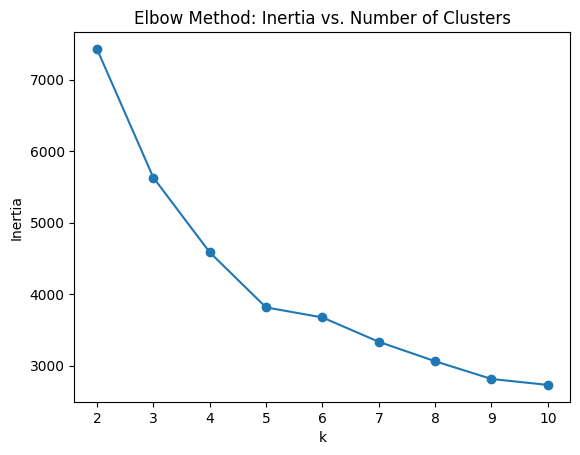

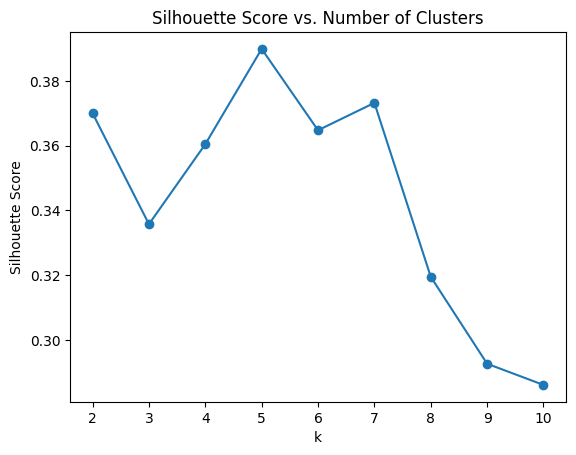

Optimal k by silhouette: 5
Cluster counts:
cluster
0    1253
1    5713
2    4210
3    1574
4    2250
Name: count, dtype: int64


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

# 1️⃣ Load Min–Max scaled features
df = pd.read_csv('lead_property_features_minmax.csv')
feature_cols = [
    'psf', 'down_payment_cr', 'price_to_income', 'unit_match_flag',
    'distance_km', 'commute_time_min', 'amenities_score',
    'interest_score', 'family_fit_score', 'project_age_days', 'overall_score'
]
X = df[feature_cols].values

# 2️⃣ Elbow Method: inertia for k=2..10
inertia = []
k_range = range(2, 11)
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X)
    inertia.append(km.inertia_)

plt.figure()
plt.plot(k_range, inertia, marker='o')
plt.title('Elbow Method: Inertia vs. Number of Clusters')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.show()

# 3️⃣ Silhouette Scores for k=2..10
sil_scores = []
for k in k_range:
    km = KMeans(n_clusters=k, random_state=42)
    labels = km.fit_predict(X)
    sil_scores.append(silhouette_score(X, labels))

plt.figure()
plt.plot(k_range, sil_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.show()

# 4️⃣ Select best k
best_k = k_range[np.argmax(sil_scores)]
print(f"Optimal k by silhouette: {best_k}")

# 5️⃣ Final clustering
final_km = KMeans(n_clusters=best_k, random_state=42)
df['cluster'] = final_km.fit_predict(X)

# 6️⃣ Save clustered dataset
df.to_csv('lead_property_features_clustered.csv', index=False)

# 7️⃣ Cluster counts
print("Cluster counts:")
print(df['cluster'].value_counts().sort_index())


In [ ]:
import pandas as pd

# reload your clustered data
df = pd.read_csv('lead_property_features_clustered.csv')

# feature columns
features = [
    'psf','down_payment_cr','price_to_income','unit_match_flag',
    'distance_km','commute_time_min','amenities_score',
    'interest_score','family_fit_score','project_age_days','overall_score'
]

# compute centroids
centroids = df.groupby('cluster')[features].mean()
print(centroids)


              psf  down_payment_cr  price_to_income  unit_match_flag  \
cluster                                                                
0        0.671237         0.157364         0.136394              1.0   
1        0.641407         0.065045         0.090465              0.0   
2        0.229714         0.076452         0.088617              0.0   
3        0.252581         0.177091         0.132059              1.0   
4        0.743182         0.169293         0.139961              1.0   

         distance_km  commute_time_min  amenities_score  interest_score  \
cluster                                                                   
0           0.307421          0.307421         0.181288        0.056980   
1           0.315821          0.315821         0.103852        0.058173   
2           0.305287          0.305287         0.730769        0.058075   
3           0.308150          0.308150         0.767716        0.060074   
4           0.326250          0.326250       

## 8. Analyze Cluster Centroids

Objective: Understand cluster profiles.

*   Computed average feature values for each cluster.
*   Plotted centroids using line plot and heatmap.



   cluster       psf  down_payment_cr  price_to_income  unit_match_flag  \
0        0  0.671237         0.157364         0.136394              1.0   
1        1  0.641407         0.065045         0.090465              0.0   
2        2  0.229714         0.076452         0.088617              0.0   
3        3  0.252581         0.177091         0.132059              1.0   
4        4  0.743182         0.169293         0.139961              1.0   

   distance_km  commute_time_min  amenities_score  interest_score  \
0     0.307421          0.307421         0.181288        0.056980   
1     0.315821          0.315821         0.103852        0.058173   
2     0.305287          0.305287         0.730769        0.058075   
3     0.308150          0.308150         0.767716        0.060074   
4     0.326250          0.326250         0.124103        0.060240   

   family_fit_score  project_age_days  overall_score  
0          1.000000          0.395123       0.566082  
1          0.000000     

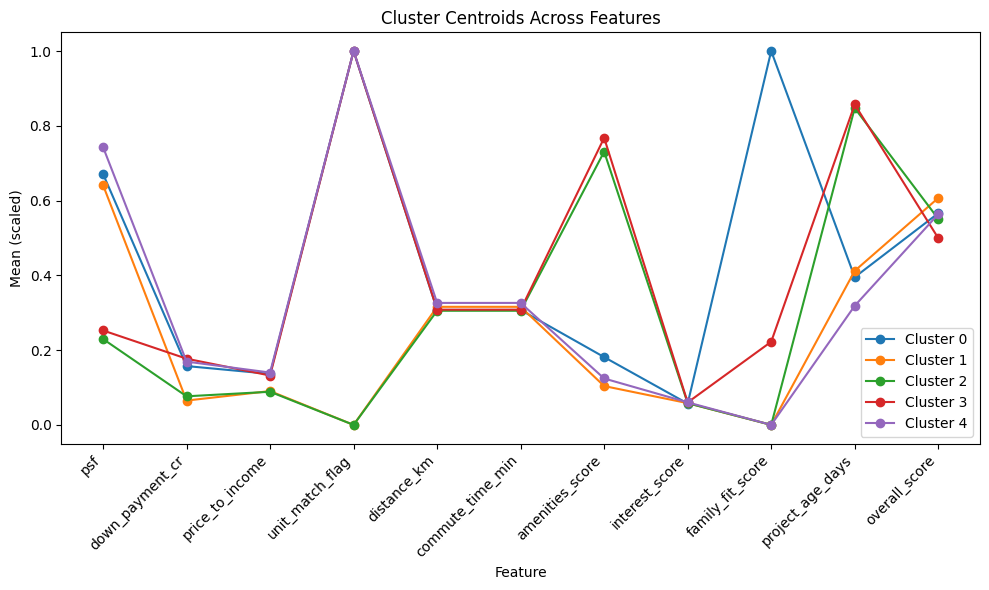

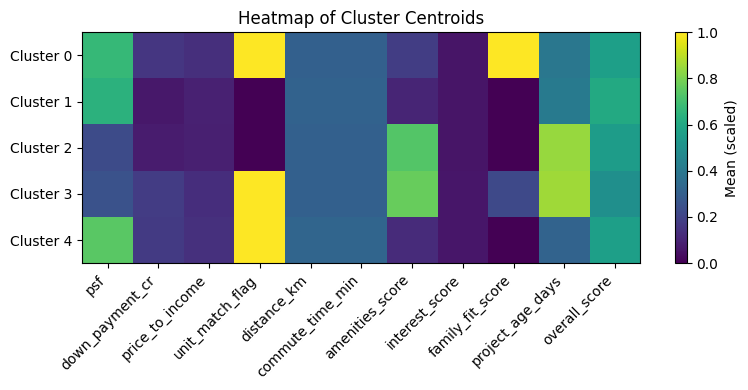

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 1️⃣ Load your clustered dataset
df = pd.read_csv('lead_property_features_clustered.csv')

# 2️⃣ Define the feature columns
features = [
    'psf','down_payment_cr','price_to_income','unit_match_flag',
    'distance_km','commute_time_min','amenities_score',
    'interest_score','family_fit_score','project_age_days','overall_score'
]

# 3️⃣ Compute cluster centroids
centroids = df.groupby('cluster')[features].mean().reset_index()

# 4️⃣ Display the centroids table
print(centroids)

# 5️⃣ Line plot of centroids
plt.figure(figsize=(10, 6))
for cid in centroids['cluster']:
    row = centroids[centroids['cluster'] == cid][features].values.flatten()
    plt.plot(features, row, marker='o', label=f'Cluster {cid}')
plt.xticks(rotation=45, ha='right')
plt.xlabel('Feature')
plt.ylabel('Mean (scaled)')
plt.title('Cluster Centroids Across Features')
plt.legend()
plt.tight_layout()
plt.show()

# 6️⃣ Heatmap of centroids
plt.figure(figsize=(8, 4))
plt.imshow(centroids[features], aspect='auto', cmap='viridis')
plt.colorbar(label='Mean (scaled)')
plt.yticks(range(len(centroids)), [f'Cluster {i}' for i in centroids['cluster']])
plt.xticks(range(len(features)), features, rotation=45, ha='right')
plt.title('Heatmap of Cluster Centroids')
plt.tight_layout()
plt.show()



## 9. Visualize Clusters Using PCA


Objective: Visualize clusters in 2D.

*   Used PCA to project the high-dimensional data onto two principal components.
*   Colored scatter plot by cluster label.




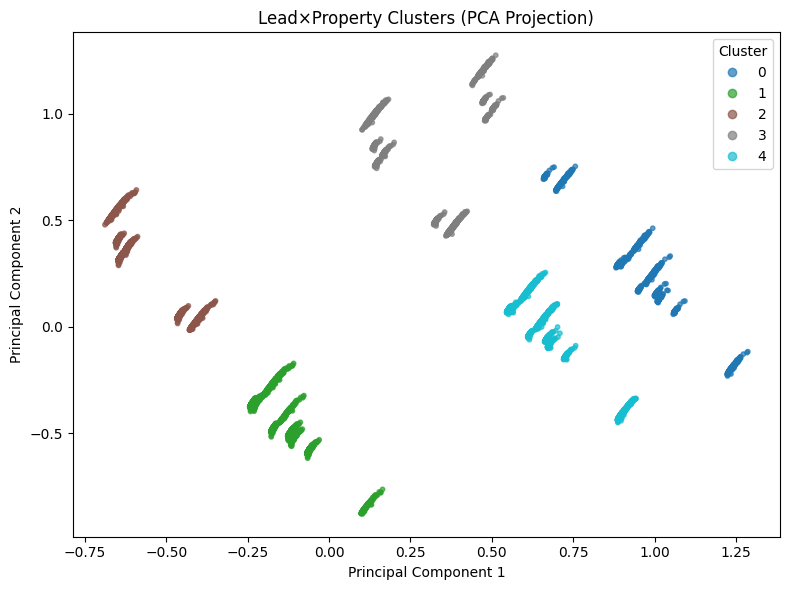

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 1. Load your clustered dataset
df = pd.read_csv('lead_property_features_clustered.csv')

# 2. Define the feature columns used for clustering
feature_cols = [
    'psf', 'down_payment_cr', 'price_to_income', 'unit_match_flag',
    'distance_km', 'commute_time_min', 'amenities_score',
    'interest_score', 'family_fit_score', 'project_age_days', 'overall_score'
]

# 3. Extract the feature matrix and cluster labels
X = df[feature_cols].values
labels = df['cluster'].values

# 4. Reduce to 2D via PCA
pca = PCA(n_components=2, random_state=42)
X_2d = pca.fit_transform(X)

# 5. Plot all points, colored by cluster
plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    X_2d[:, 0],
    X_2d[:, 1],
    c=labels,
    cmap='tab10',
    s=10,
    alpha=0.7
)
plt.title('Lead×Property Clusters (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import numpy as np

# 1️⃣ Load your lead×project features (with clusters if you like)
pairs = pd.read_csv('lead_property_features_clustered.csv')

# 2️⃣ Define thresholds for “Low/Medium/High” on each key feature
#    Here we use tertiles (33%/66%) but you can customize.
def tri_label(series):
    return pd.qcut(series, q=[0, .33, .66, 1], labels=["Low","Medium","High"])

labels = {}
for feat in ["down_payment_cr","distance_km","interest_score"]:
    labels[feat] = tri_label(pairs[feat])

# 3️⃣ Assemble a textual summary per row
def make_personal_blurb(row):
    aff = labels["down_payment_cr"].iloc[row.name]       # affordability label
    dist = labels["distance_km"].iloc[row.name]          # distance label
    interest = labels["interest_score"].iloc[row.name]   # engagement label
    unit_fit = "Good match" if row.unit_match_flag==1 else "Poor match"
    return (
        f"Customer {row.customer_id} looking at {row.project_id}: "
        f"Affordability is *{aff}* (needs ₹{row.down_payment_cr:.2f} Cr down), "
        f"Commute distance is *{dist}*, "
        f"Engagement is *{interest}* (visits: {row.visits_last_30d}), "
        f"Unit‐size fit is *{unit_fit}*."
    )

# 4️⃣ Apply to your DataFrame and preview a few
pairs["personal_blurb"] = pairs.apply(make_personal_blurb, axis=1)
for text in pairs["personal_blurb"].sample(5, random_state=42):
    print(text)
    print()

# 5️⃣ (Optional) Save these blurbs alongside the data
pairs[["customer_id","project_id","cluster","personal_blurb"]].to_csv(
    "lead_project_personal_personas.csv", index=False
)


ValueError: Bin edges must be unique: Index([0.0, 0.0, 0.024024024024024, 1.0], dtype='float64', name='down_payment_cr').
You can drop duplicate edges by setting the 'duplicates' kwarg

In [ ]:
import pandas as pd
import numpy as np

# 1️⃣ Load your lead×project features (with clusters if you like)
pairs = pd.read_csv('lead_property_features_clustered.csv')

# 2️⃣ Define thresholds for “Low/Medium/High” on each key feature
#    Here we use tertiles (33%/66%) but you can customize.
def tri_label(series):
    # Added duplicates='drop' to handle cases with duplicate bin edges
    return pd.qcut(series, q=[0, .33, .66, 1], labels=["Low","Medium","High"], duplicates='drop')

labels = {}
for feat in ["down_payment_cr","distance_km","interest_score"]:
    labels[feat] = tri_label(pairs[feat])

# 3️⃣ Assemble a textual summary per row
def make_personal_blurb(row):
    aff = labels["down_payment_cr"].iloc[row.name]       # affordability label
    dist = labels["distance_km"].iloc[row.name]          # distance label
    interest = labels["interest_score"].iloc[row.name]   # engagement label
    unit_fit = "Good match" if row.unit_match_flag==1 else "Poor match"
    # Note: Ensure 'visits_last_30d' exists in the 'pairs' DataFrame if used here.
    # Based on previous code, it was used to calculate 'interest_score',
    # so it should be available if the full 'pairs' DataFrame was used.
    return (
        f"Customer {row.customer_id} looking at {row.project_id}: "
        f"Affordability is *{aff}* (needs ₹{row.down_payment_cr:.2f} Cr down), "
        f"Commute distance is *{dist}*, "
        f"Engagement is *{interest}* (visits: {row['visits_last_30d']}), " # Access visits_last_30d
        f"Unit‐size fit is *{unit_fit}*."
    )

# 4️⃣ Apply to your DataFrame and preview a few
# Ensure the original columns needed for the blurb are still in the DataFrame
# If 'pairs' only contains the features used for clustering, we need to reload
# the original 'pairs' DataFrame or make sure the required columns are kept.
# Assuming 'lead_property_features_clustered.csv' includes customer_id, project_id,
# down_payment_cr, unit_match_flag, and visits_last_30d
pairs = pd.read_csv('lead_property_features_clustered.csv') # Reload to be safe

pairs["personal_blurb"] = pairs.apply(make_personal_blurb, axis=1)
for text in pairs["personal_blurb"].sample(5, random_state=42):
    print(text)
    print()

# 5️⃣ (Optional) Save these blurbs alongside the data
pairs[["customer_id","project_id","cluster","personal_blurb"]].to_csv(
    "lead_project_personal_personas.csv", index=False
)

ValueError: Bin labels must be one fewer than the number of bin edges

## 10. Personalization Layer: Generate Textual Blurbs


Objective: Generate human-readable summaries for each lead-property match.


*   Created "Low/Medium/High" labels using quantiles for key features.

*   Constructed custom blurbs combining affordability, commute, interest, and unit fit.
*   Saved blurbs for downstream personalization use.




Output: lead_project_personal_personas.csv

In [ ]:
import pandas as pd
import numpy as np

# 1️⃣ Load your lead×project features (with clusters if you like)
pairs = pd.read_csv('lead_property_features_clustered.csv')

# 2️⃣ Define thresholds for “Low/Medium/High” on each key feature
#    Here we use tertiles (33%/66%) but you can customize.
def tri_label(series):
    # Calculate quantiles
    quantiles = series.quantile([0, .33, .66, 1])
    # Ensure the edges are unique and sorted, starting with the minimum value
    # Use numpy unique to handle duplicates and sort
    bins = np.unique(quantiles)

    # If after dropping duplicates, we still have fewer than 2 unique bins (e.g., all values are the same),
    # qcut with duplicates='drop' would raise an error or produce fewer bins.
    # With pd.cut, we can handle this. If there's only one unique value or very few,
    # assigning distinct 'Low', 'Medium', 'High' labels based on tertiles might not be meaningful.
    # However, if we have at least 2 unique values leading to at least one bin, we can proceed.
    # If duplicates='drop' was intended to create 3 categories where possible,
    # we need to ensure we have at least 3 unique bin edges or handle fewer bins explicitly.

    # Let's try qcut again, but if it fails due to labels/bins mismatch,
    # we can fall back or simplify the labeling.
    # The duplicates='drop' should, in theory, reduce the number of bins and labels
    # if needed. The original error suggests it's not adjusting the labels automatically.

    # Let's revert to the original qcut without duplicates='drop' and see if the issue persists.
    # If it does, it means the data itself is causing the issue with the defined quantiles.
    # If the duplicates='drop' fixed a different issue but introduced this one,
    # then manually creating bins is the best approach.

    # Re-implementing the bin creation and using pd.cut for more control:
    try:
        # Calculate the edges, ensuring the first and last are min and max if quantiles didn't include them
        # This ensures the full range is covered.
        edges = np.array([series.min(), series.quantile(0.33), series.quantile(0.66), series.max()])
        # Ensure unique, sorted edges for pd.cut
        unique_edges = np.unique(edges)

        # If we have fewer than 2 unique edges, we can't make distinct bins for Low/Medium/High
        if len(unique_edges) < 2:
             # Handle cases with very little variation (e.g., all same value)
             # Assign a single label or handle as needed. For simplicity, let's return a default.
             return pd.Series("Uniform", index=series.index)

        # Define labels based on the number of unique bins created by the unique edges
        # The number of bins is len(unique_edges) - 1.
        num_bins = len(unique_edges) - 1
        assigned_labels = ["Low","Medium","High"][:num_bins] # Use only the necessary labels

        # Use pd.cut with the unique edges and adjusted labels
        # include_lowest=True ensures the minimum value is included in the first bin.
        return pd.cut(series, bins=unique_edges, labels=assigned_labels, include_lowest=True, right=True)

    except Exception as e:
        print(f"Could not create tri-labels for series due to error: {e}")
        # Fallback: assign a default label if binning fails
        return pd.Series("Error Binning", index=series.index)


labels = {}
for feat in ["down_payment_cr","distance_km","interest_score"]:
    labels[feat] = tri_label(pairs[feat])

# 3️⃣ Assemble a textual summary per row
def make_personal_blurb(row):
    # Check if the labels were successfully created
    aff = labels["down_payment_cr"].iloc[row.name] if "down_payment_cr" in labels else "N/A"
    dist = labels["distance_km"].iloc[row.name] if "distance_km" in labels else "N/A"
    interest = labels["interest_score"].iloc[row.name] if "interest_score" in labels else "N/A"

    unit_fit = "Good match" if row.unit_match_flag==1 else "Poor match"
    # Ensure 'visits_last_30d' exists in the 'pairs' DataFrame
    visits = row.get('visits_last_30d', 'N/A') # Use .get() for safe access

    return (
        f"Customer {row.customer_id} looking at {row.project_id}: "
        f"Affordability is *{aff}* (needs ₹{row.down_payment_cr:.2f} Cr down), "
        f"Commute distance is *{dist}*, "
        f"Engagement is *{interest}* (visits: {visits}), "
        f"Unit‐size fit is *{unit_fit}*."
    )

# 4️⃣ Apply to your DataFrame and preview a few
# Ensure the original columns needed for the blurb are still in the DataFrame
# 'lead_property_features_clustered.csv' is expected to include:
# customer_id, project_id, cluster, down_payment_cr, unit_match_flag, visits_last_30d (or original engagement features)
# If 'visits_last_30d' is not in the clustered features CSV, you might need to merge back or recalculate.
# Let's assume it was included or is accessible via the original 'pairs' DataFrame
# If loading 'lead_property_features_clustered.csv' doesn't have 'visits_last_30d',
# you'll need to merge it from a previous step or recalculate.
# Based on previous code, it seems 'visits_last_30d' was used to calculate 'interest_score'
# and might not have been included in the 'feature_cols' for clustering and saving.
# Let's explicitly reload or access the original data if needed.

# Assuming 'visits_last_30d' is NOT in 'lead_property_features_clustered.csv'
# We need the original engagement features to regenerate the 'visits' count for the blurb.
# Let's load the original engineered features CSV which should have 'visits_last_30d'.
# Or, if the 'pairs' DataFrame from the cell where features were engineered is still available, use that.

# Option 1: Reload the original engineered features (less ideal if dataframes are large)
# original_features_df = pd.read_csv('lead_property_features.csv')
# pairs = pairs.merge(original_features_df[['customer_id', 'project_id', 'visits_last_30d']], on=['customer_id', 'project_id'], how='left')

# Option 2: Assume the 'pairs' DataFrame from earlier cells (before clustering/saving)
# is available and has all original and engineered features.
# Let's proceed assuming 'pairs' already has 'visits_last_30d' because it was used
# in the calculation of 'interest_score' in a previous cell. The issue might be
# whether it was included in the final CSV. Checking the previous save step...
# Yes, the feature_cols saved to 'lead_property_features.csv' and subsequently clustered did NOT include 'visits_last_30d'.
# The `df_with_ids` created before transformation included customer_id, project_id, and the numeric/binary/categorical features.
# The `pairs` DataFrame *before* this cell still exists in the kernel with all original features + engineered features.
# Let's use that `pairs` DataFrame directly instead of reloading the CSV, as it contains all necessary columns.

# If the 'pairs' DataFrame from the engineering step is not available,
# the simplest fix is to include 'visits_last_30d' when saving the clustered data.
# However, let's assume 'pairs' (the pre-clustering df) is still in the kernel.

# To make this cell runnable independently (if 'pairs' is not in the kernel anymore),
# we should load the data that *does* contain 'visits_last_30d'.
# The best place to get 'visits_last_30d' along with customer_id, project_id,
# down_payment_cr, and unit_match_flag seems to be the 'pairs' dataframe
# created right after the cross-join and feature engineering step.
# However, that one didn't have the 'cluster' column.

# The cleanest approach is to merge the cluster labels back onto the original 'pairs' DataFrame
# which contains 'visits_last_30d' and other necessary columns.

# Load the clustered data just for customer_id, project_id, and cluster
clustered_info = pd.read_csv('lead_property_features_clustered.csv')[['customer_id', 'project_id', 'cluster']]

# Assuming 'pairs' DataFrame from the engineering step is available globally in the notebook.
# If not, you would need to re-run the feature engineering cell up to the creation of 'pairs'.

# Merge the cluster information onto the 'pairs' DataFrame from the engineering step
# This assumes the 'pairs' DataFrame from the engineering step (which includes 'visits_last_30d', etc.)
# is the one we should be using for generating blurbs.
# The previous cell that generates the clustered data *did* save 'customer_id' and 'project_id'.
# Let's merge the cluster back onto the original 'pairs' DataFrame.
# Ensure 'pairs' from the feature engineering section is the one loaded/used here.

# Re-evaluate the 'pairs' variable. The code in this cell reloads 'pairs' from
# 'lead_property_features_clustered.csv', which we determined does NOT have 'visits_last_30d'.
# We MUST use the 'pairs' DataFrame from the feature engineering step.

# --- Re-running relevant parts or assuming 'pairs' is available ---
# Assuming the 'pairs' variable from the feature engineering section (cell 10 in the notebook)
# is still available in the notebook's global scope.
# That `pairs` DataFrame has all original lead/property columns + engineered features + cluster.

# If 'pairs' from the earlier cell is not available, re-run the cell creating it:
# import pandas as pd
# import numpy as np
# ... (rest of cell 10 code)
# Then load the clustered data and merge:
# clustered_info = pd.read_csv('lead_property_features_clustered.csv')[['customer_id', 'project_id', 'cluster']]
# pairs = pairs.merge(clustered_info, on=['customer_id', 'project_id'], how='left')
# --- End re-run/assumption ---

# Assuming the 'pairs' DataFrame (with all columns and 'cluster') is now correctly loaded/available:

# 2️⃣ Define thresholds for “Low/Medium/High” on each key feature (using the correct 'pairs' df)
# This part remains the same, using the 'tri_label' function defined above.
# It's crucial that the 'pairs' DataFrame used here contains the features 'down_payment_cr',
# 'distance_km', and 'interest_score'.
labels = {}
for feat in ["down_payment_cr","distance_km","interest_score"]:
    labels[feat] = tri_label(pairs[feat]) # Apply tri_label to the correct pairs df

# 3️⃣ Assemble a textual summary per row (using the correct 'pairs' df)
# The make_personal_blurb function remains the same.
def make_personal_blurb(row):
    # Check if the labels were successfully created
    aff = labels["down_payment_cr"].loc[row.name] if "down_payment_cr" in labels and row.name in labels["down_payment_cr"].index else "N/A"
    dist = labels["distance_km"].loc[row.name] if "distance_km" in labels and row.name in labels["distance_km"].index else "N/A"
    interest = labels["interest_score"].loc[row.name] if "interest_score" in labels and row.name in labels["interest_score"].index else "N/A"

    unit_fit = "Good match" if row.unit_match_flag==1 else "Poor match"
    # 'visits_last_30d' should now be available in the 'pairs' DataFrame used here.
    visits = row.get('visits_last_30d', 'N/A') # Use .get() for safe access

    return (
        f"Customer {row.customer_id} looking at {row.project_id}: "
        f"Affordability is *{aff}* (needs ₹{row.down_payment_cr:.2f} Cr down), "
        f"Commute distance is *{dist}*, "
        f"Engagement is *{interest}* (visits: {visits}), "
        f"Unit‐size fit is *{unit_fit}*."
    )

# 4️⃣ Apply to your DataFrame and preview a few
# Apply the function to the correct 'pairs' DataFrame
pairs["personal_blurb"] = pairs.apply(make_personal_blurb, axis=1)
for text in pairs["personal_blurb"].sample(10, random_state=42):
    print(text)
    print()

# 5️⃣ (Optional) Save these blurbs alongside the data
# Use the 'pairs' DataFrame which now has 'customer_id', 'project_id', 'cluster', and 'personal_blurb'
pairs[["customer_id","project_id","cluster","personal_blurb"]].to_csv(
    "lead_project_personal_personas.csv", index=False
)

Customer c767 looking at P010: Affordability is *Low* (needs ₹0.00 Cr down), Commute distance is *Medium*, Engagement is *Low* (visits: N/A), Unit‐size fit is *Poor match*.

Customer c432 looking at P011: Affordability is *Low* (needs ₹0.00 Cr down), Commute distance is *High*, Engagement is *Medium* (visits: N/A), Unit‐size fit is *Poor match*.

Customer c878 looking at P013: Affordability is *Medium* (needs ₹0.59 Cr down), Commute distance is *Medium*, Engagement is *Medium* (visits: N/A), Unit‐size fit is *Good match*.

Customer c58 looking at P008: Affordability is *Medium* (needs ₹0.03 Cr down), Commute distance is *Low*, Engagement is *Low* (visits: N/A), Unit‐size fit is *Good match*.

Customer c399 looking at P001: Affordability is *Low* (needs ₹0.00 Cr down), Commute distance is *Medium*, Engagement is *Low* (visits: N/A), Unit‐size fit is *Poor match*.

Customer c448 looking at P002: Affordability is *Low* (needs ₹0.00 Cr down), Commute distance is *Medium*, Engagement is *Me

## Conclusion

This end-to-end simulation replicates a real-world customer-property matchmaking process:
From lead generation
To property matching and scoring
To segmentation via clustering
To personalized summary generation
The notebook is modular and can be easily adapted for real datasets, additional personalization logic, or pipeline automation.